In [1]:
from collections import defaultdict

import cv2
from PIL import Image, ImageDraw
import numpy as np
import random
import os

import math
from tqdm.contrib import itertools

from yacs.config import CfgNode as CN

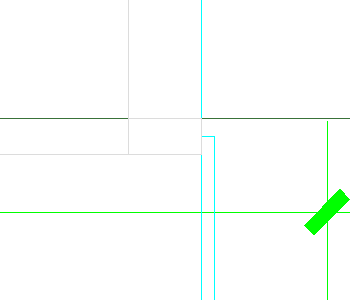

In [2]:
ori_img = cv2.imread('../static/img/b1.png')
# ori_img = ori_img[7000:8000, 5000:6000, :]
ori_img = ori_img[7300:7600, 5250:5600, :]
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
Image.fromarray(ori_img)

In [3]:
from detect_line import detect_lines
lines, total_lines, all_elines = detect_lines(ori_img)

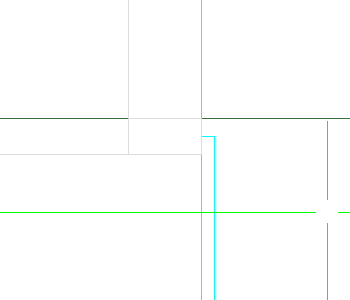

In [5]:
white = np.ones_like(ori_img) * 255
for line in lines:
    color = line[2]
    pt1 = line[0]
    pt2 = line[1]
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white)

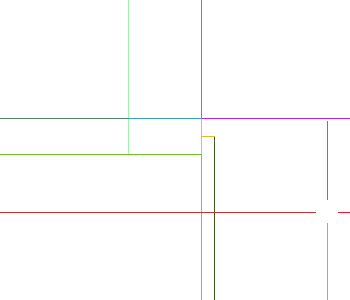

In [6]:
white = np.ones_like(ori_img) * 255
for line in lines:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    pt1 = line[0]
    pt2 = line[1]
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white)

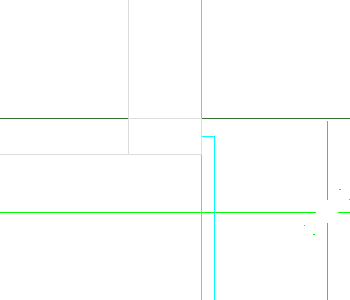

In [5]:
white = np.ones_like(ori_img) * 255
for line in total_lines:
    cv2.line(white, line[0], line[1], line[2], 1)
Image.fromarray(white)

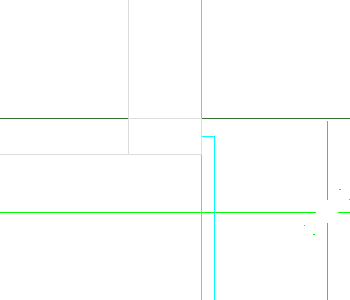

In [6]:
white = np.ones_like(ori_img) * 255
for line in all_elines:
    cv2.line(white, line[0], line[1], line[2], 1)
Image.fromarray(white)

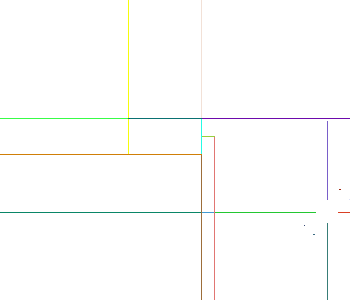

In [7]:
white = np.ones_like(ori_img) * 255
for line in all_elines:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, line[0], line[1], color, 1)
Image.fromarray(white)

In [8]:
len(lines)

20

In [56]:
from detect_line import *

def _get_eline_faster(img, cfg=get_cfg_defaults()):
    """
    快的get_eline

    :param img: ndarray 图片
    :param cfg:
    :return: 带有斜率，颜色的线元
    """
    thin = get_thin(img, cfg)
    w, h = thin.shape[:2]
    thin_pad = np.ones((w + 1, h + 1), dtype=np.uint8) * 255
    thin_pad[:-1, :-1] = thin
    img_pad = np.ones((w + 1, h + 1, 3), dtype=np.uint8) * 255
    img_pad[:-1, :-1, :] = img
    h_line = []

    nowhite = np.where(thin_pad != 255)
    nowhite = list(zip(*nowhite))
    if len(nowhite) == 0:
        return []
    n1 = sorted(nowhite, key=lambda x: (x[0], x[1]))
    n2 = sorted(nowhite, key=lambda x: (x[1], x[0]))
    head = n1[0]
    tail = n1[0]
    for i, it in enumerate(n1[1:]):
        if it[0] == n1[i][0] and it[1] - n1[i][1] == 1 and (img[it] == img[n1[i]]).all():
            tail = it
            continue
        h_line.append([head[0], head[1], tail[0], tail[1]])
        head = it
        tail = it
    if head != tail:
        h_line.append([head[0], head[1], tail[0], tail[1]])

    v_line = []
    for i, it in enumerate(n2[1:]):
        if it[1] == n2[i][1] and it[0] - n2[i][0] == 1 and (img[it] == img[n2[i]]).all():
            tail = it
            continue
        v_line.append([head[0], head[1], tail[0], tail[1]])
        head = it
        tail = it
    if head != tail:
        v_line.append([head[0], head[1], tail[0], tail[1]])

    dot1 = [(line[0], line[1]) for line in h_line if (line[0], line[1]) == (line[2], line[3])]
    dot2 = [(line[0], line[1]) for line in v_line if (line[0], line[1]) == (line[2], line[3])]
    dots = list(set(dot2) - (set(dot2) - set(dot1)))
    dots = [[d[0], d[1], d[0], d[1]] for d in dots]
    h_line = [line for line in h_line if (line[0], line[1]) != (line[2], line[3])]
    v_line = [line for line in v_line if (line[0], line[1]) != (line[2], line[3])]
    # 创建Eline, 上颜色，上方向
    elines = []
    for index, eline in enumerate([*v_line, *h_line, *dots]):
        # if index != 9:
        #     continue

        pt1 = (eline[0], eline[1])
        pt2 = (eline[2], eline[3])

        # 生成所有xy坐标
        x_coords = range(pt1[0], pt2[0] + 1) if pt2[0] > pt1[0] else range(pt1[0], pt2[0] - 1, -1)
        y_coords = range(pt1[1], pt2[1] + 1) if pt2[1] > pt1[1] else range(pt1[1], pt2[1] - 1, -1)
        colors = defaultdict(int)
        for x, y in zip(x_coords, y_coords):
            colors[tuple([int(it) for it in img[(x, y)]])] += 1
        color = max(colors, key=colors.get)

        # color = tuple([int(it) for it in img[pt1]])

        k1 = pt2[1] - pt1[1]
        k2 = pt2[0] - pt1[0]
        volume = max(abs(pt2[0] - pt1[0]), abs(pt2[1] - pt1[1])) + 1

        ### 补丁，在这里吧eline的xy坐标转回去
        el = ELine((pt1[1], pt1[0]), (pt2[1], pt2[0]), 'dot' if pt1 == pt2 else 'line', k1, k2, color, volume)
        # 加方向
        minx, maxx = sorted([pt1[0], pt2[0]])
        miny, maxy = sorted([pt1[1], pt2[1]])
        if tuple(img_pad[minx - 1, miny - 1]) == color:
            el.append_dir(1)
        if tuple(img_pad[maxx + 1, maxy + 1]) == color:
            el.append_dir(1)
        if tuple(img_pad[maxx + 1, miny - 1]) == color:
            el.append_dir(-1)
        if tuple(img_pad[minx - 1, maxy + 1]) == color:
            el.append_dir(-1)

        elines.append(el)

    return elines

In [8]:
elines = _get_eline_faster(ori_img)

NameError: name '_get_eline_faster' is not defined

In [9]:
white = np.ones_like(ori_img) * 255
for line in elines[5:10]:
    color = line.color
    pt1 = line.pt1
    pt2 = line.pt2
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white)

NameError: name 'elines' is not defined

NameError: name 'n1' is not defined